In [6]:
import numpy as np
import pandas as pd

In [7]:
df = pd.read_csv("../data/top_artists_genres.csv", encoding="utf-8", header=None)
df.columns = ["Country Code", "Top artists", "Top genres"]
df.head()

,Country Code,Top artists,Top genres
0,at,"Jazeek, Bruno Mars, Billie Eilish, Linkin Park...","german hip hop, afro house, german pop, nu met..."
1,be,"Bruno Mars, Billie Eilish, GIMS, Gracie Abrams...","pop urbaine, french pop, afro house, chanson, ..."
2,dk,"Annika, Lamin, Gilli, Benny Jamz, Tobias Rahim...","dansktop, norwegian rap, west coast hip hop, n..."
3,fr,"GIMS, SDM, Bruno Mars, Stromae, Pomme, Arcane,...","pop urbaine, french pop, chanson, zouk, variét..."
4,de,"Jazeek, Luciano, Bruno Mars, Linkin Park, LACA...","german hip hop, german pop, afro house, nu met..."


## Calculate Similarity Matrices

In [8]:
df["Top Artists"] = df.iloc[:, 1].apply(lambda x: set(str(x).split(", ")[:30]))     # Select only the Top30 for each country
df["Top Genres"] = df.iloc[:, 2].apply(lambda x: set(str(x).split(", ")[:30]))      # Select ony the Top30 for each country (some has less than 30) 

countries = df.iloc[:, 0].values
num_countries = len(countries)

artists_similarity = np.zeros((num_countries, num_countries), dtype=int)
genres_similarity = np.zeros((num_countries, num_countries), dtype=int)

for i in range(num_countries):
    for j in range(i, num_countries):       # Only compute the upper triangle (as it is a symmetric matrix)
        if i == j:
            artists_similarity[i, j] = len(df["Top Artists"].iloc[i])
            genres_similarity[i, j] = len(df["Top Genres"].iloc[i])
        else:
            artists_similarity[i, j] = artists_similarity[j, i] = len(df["Top Artists"].iloc[i] & df["Top Artists"].iloc[j])
            genres_similarity[i, j] = genres_similarity[j, i] = len(df["Top Genres"].iloc[i] & df["Top Genres"].iloc[j])

artists_similarity_df = pd.DataFrame(artists_similarity, index=countries, columns=countries)
genres_similarity_df = pd.DataFrame(genres_similarity, index=countries, columns=countries)

artists_similarity_df.to_csv("../data/artists_similarity.csv", encoding="utf-8")
genres_similarity_df.to_csv("../data/genres_similarity.csv", encoding="utf-8")
print("Similarity matrices saved.")

Similarity matrices saved.


### Check if they have been correctly computed

In [9]:
artists_similarity_df.head()

,at,be,dk,fr,de,it,lu,nl,ch,gb,...,bg,md,am,cz,ge,me,rs,az,sm,au
at,30,12,5,5,24,2,15,12,18,11,...,5,10,10,8,10,10,4,10,10,11
be,12,30,6,12,11,2,22,14,22,12,...,7,10,10,8,12,10,7,10,10,11
dk,5,6,30,4,5,2,6,5,6,6,...,4,6,6,5,6,6,4,6,6,6
fr,5,12,4,30,5,2,9,4,10,5,...,7,6,6,5,8,6,7,6,6,5
de,24,11,5,5,30,2,14,11,16,10,...,5,10,10,8,9,10,4,10,10,9


In [10]:
shared_artists = df["Top Artists"].iloc[0] & df["Top Artists"].iloc[1]
print(f"Shared artists between {countries[0]} and {countries[1]}:")
print(f"Total: {len(shared_artists)}, {shared_artists}")
print()

shared_genres = df["Top Genres"].iloc[0] & df["Top Genres"].iloc[1]
print(f"\nShared genres between {countries[0]} and {countries[1]}:")
print(f"Total: {len(shared_genres)}, {shared_genres}")

Shared artists between at and be:
Total: 12, {'HUGEL', 'Billie Eilish', 'Bruno Mars', 'Gigi Perez', 'Gracie Abrams', 'Lady Gaga', 'David Guetta', 'Chappell Roan', 'ROSÉ', 'Myles Smith', 'Linkin Park', 'The Weeknd'}


Shared genres between at and be:
Total: 16, {'nu metal', 'latin house', 'tropical house', 'edm', 'afro house', 'dance', 'alternative metal', 'house', 'pop', 'art pop', 'tech house', 'rage rap', 'rock', 'rap metal', 'k-pop', 'melodic house'}


## Normalice the Similarity Matrices

### Normalice with Jaccard Index

The Jaccard Index is computed by using the intersection size divided by the union size, also called intersection over union (IoU).

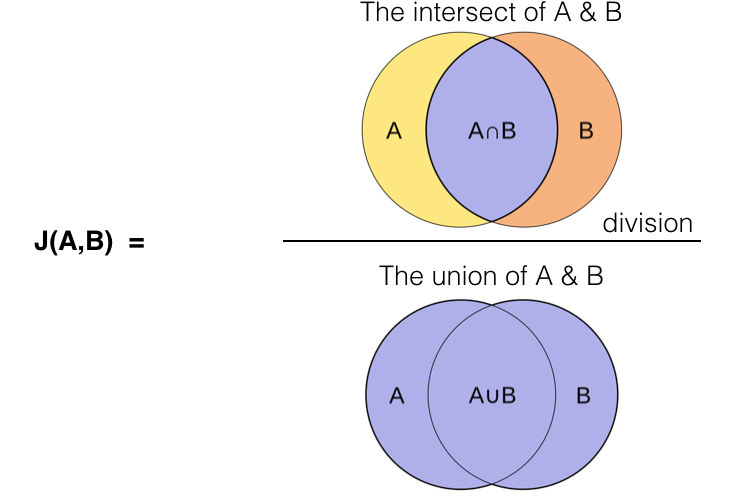

The Jaccard Index can be useful, but may be unfair to countries with less than 30 genres.

In [13]:
jaccard_normalized_artists_similarity = np.zeros((num_countries, num_countries))
jaccard_normalized_genres_similarity = np.zeros((num_countries, num_countries))

for i in range(num_countries):
    for j in range(i, num_countries):       # Only compute upper triangle (symmetry)
        if i == j:
            jaccard_normalized_artists_similarity[i, j] = jaccard_normalized_genres_similarity[i, j] = 1        # Full similarity with itself
        else:
            total_artists = len(df["Top Artists"].iloc[i] | df["Top Artists"].iloc[j])
            total_genres = len(df["Top Genres"].iloc[i] | df["Top Genres"].iloc[j])

            jaccard_normalized_artists_similarity[i, j] = jaccard_normalized_artists_similarity[j, i] = (
                artists_similarity[i, j] / total_artists if total_artists > 0 else 0
            )
            jaccard_normalized_genres_similarity[i, j] = jaccard_normalized_genres_similarity[j, i] = (
                genres_similarity[i, j] / total_genres if total_genres > 0 else 0
            )

jaccard_normalized_artists_similarity_df = pd.DataFrame(jaccard_normalized_artists_similarity, index=countries, columns=countries)
jaccard_normalized_genres_similarity_df = pd.DataFrame(jaccard_normalized_genres_similarity, index=countries, columns=countries)

jaccard_normalized_artists_similarity_df.to_csv("../data/jaccard_normalized_artists_similarity.csv", encoding="utf-8")
jaccard_normalized_genres_similarity_df.to_csv("../data/jaccard_normalized_genres_similarity.csv", encoding="utf-8")
print("Jaccard normalized similarity matrices saved.")

Jaccard normalized similarity matrices saved.


In [12]:
jaccard_normalized_artists_similarity_df.head()

,at,be,dk,fr,de,it,lu,nl,ch,gb,...,bg,md,am,cz,ge,me,rs,az,sm,au
at,1.000000,0.250000,0.090909,0.090909,0.666667,0.034483,0.333333,0.250000,0.428571,0.224490,...,0.090909,0.200000,0.200000,0.153846,0.200000,0.200000,0.071429,0.200000,0.200000,0.224490
be,0.250000,1.000000,0.111111,0.250000,0.224490,0.034483,0.578947,0.304348,0.578947,0.250000,...,0.132075,0.200000,0.200000,0.153846,0.250000,0.200000,0.132075,0.200000,0.200000,0.224490
dk,0.090909,0.111111,1.000000,0.071429,0.090909,0.034483,0.111111,0.090909,0.111111,0.111111,...,0.071429,0.111111,0.111111,0.090909,0.111111,0.111111,0.071429,0.111111,0.111111,0.111111
fr,0.090909,0.250000,0.071429,1.000000,0.090909,0.034483,0.176471,0.071429,0.200000,0.090909,...,0.132075,0.111111,0.111111,0.090909,0.153846,0.111111,0.132075,0.111111,0.111111,0.090909
de,0.666667,0.224490,0.090909,0.090909,1.000000,0.034483,0.304348,0.224490,0.363636,0.200000,...,0.090909,0.200000,0.200000,0.153846,0.176471,0.200000,0.071429,0.200000,0.200000,0.176471


### Normalice with Dice-Sørensen Coefficient

The Dice-Sørensen Coefficient uses the total size of the sets in the denominator to avoid penalizing countries with fewer genres or artists.

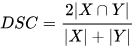

Dice-Sørensen favors intersection and reduces the effect of list size.

In [20]:
dice_sorensen_normalized_artists_similarity = np.zeros((num_countries, num_countries))
dice_sorensen_normalized_genres_similarity = np.zeros((num_countries, num_countries))

for i in range(num_countries):
    for j in range(i, num_countries):       # Only compute upper triangle (symmetry)
        if i == j:
            dice_sorensen_normalized_artists_similarity[i, j] = dice_sorensen_normalized_genres_similarity[i, j] = 1        # Full similarity with itself
        else:
            common_artists = len(df["Top Artists"].iloc[i] & df["Top Artists"].iloc[j])
            common_genres = len(df["Top Genres"].iloc[i] & df["Top Genres"].iloc[j])

            dice_sorensen_artists = (2 * common_artists) / (len(df["Top Artists"].iloc[i]) + len(df["Top Artists"].iloc[j])) if (len(df["Top Artists"].iloc[i]) + len(df["Top Artists"].iloc[j])) > 0 else 0
            dice_sorensen_genres = (2 * common_genres) / (len(df["Top Genres"].iloc[i]) + len(df["Top Genres"].iloc[j])) if (len(df["Top Genres"].iloc[i]) + len(df["Top Genres"].iloc[j])) > 0 else 0

            dice_sorensen_normalized_artists_similarity[i, j] = dice_sorensen_normalized_artists_similarity[j, i] = dice_sorensen_artists
            dice_sorensen_normalized_genres_similarity[i, j] = dice_sorensen_normalized_genres_similarity[j, i] = dice_sorensen_genres

dice_sorensen_normalized_artists_similarity_df = pd.DataFrame(dice_sorensen_normalized_artists_similarity, index=df.index, columns=df.index)
normalized_genres_similarity_df = pd.DataFrame(dice_sorensen_normalized_genres_similarity, index=df.index, columns=df.index)

dice_sorensen_normalized_artists_similarity_df.to_csv("../data/dice_sorensen_normalized_artists_similarity.csv", encoding="utf-8")
normalized_genres_similarity_df.to_csv("../data/dice_sorensen_normalized_genres_similarity.csv", encoding="utf-8")
print("Dice-Sørensen normalized similarity matrices saved.")


Dice-Sørensen normalized similarity matrices saved.


In [21]:
dice_sorensen_normalized_artists_similarity_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.000000,0.400000,0.166667,0.166667,0.800000,0.066667,0.500000,0.400000,0.600000,0.366667,...,0.166667,0.333333,0.333333,0.266667,0.333333,0.333333,0.133333,0.333333,0.333333,0.366667
1,0.400000,1.000000,0.200000,0.400000,0.366667,0.066667,0.733333,0.466667,0.733333,0.400000,...,0.233333,0.333333,0.333333,0.266667,0.400000,0.333333,0.233333,0.333333,0.333333,0.366667
2,0.166667,0.200000,1.000000,0.133333,0.166667,0.066667,0.200000,0.166667,0.200000,0.200000,...,0.133333,0.200000,0.200000,0.166667,0.200000,0.200000,0.133333,0.200000,0.200000,0.200000
3,0.166667,0.400000,0.133333,1.000000,0.166667,0.066667,0.300000,0.133333,0.333333,0.166667,...,0.233333,0.200000,0.200000,0.166667,0.266667,0.200000,0.233333,0.200000,0.200000,0.166667
4,0.800000,0.366667,0.166667,0.166667,1.000000,0.066667,0.466667,0.366667,0.533333,0.333333,...,0.166667,0.333333,0.333333,0.266667,0.300000,0.333333,0.133333,0.333333,0.333333,0.300000
